In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

import torch
import tqdm

In [2]:
def sinkhorn(C, eps=0.05, n_iters=100):
    P = torch.exp(-C / eps)
    for _ in range(n_iters):
        P = P / (P.sum(dim=-1, keepdim=True) + 1e-8)
        P = P / (P.sum(dim=-2, keepdim=True) + 1e-8)
    return P

In [27]:
cm = torch.tensor([[0.2, -0.2],
                   [0.3, -0.3]]) * 1e-5
sinkhorn(cm, eps=1e-4)

tensor([[0.5025, 0.4975],
        [0.4975, 0.5025]])

In [28]:
sinkhorn(cm).argmax(dim=-1)

tensor([0, 1])

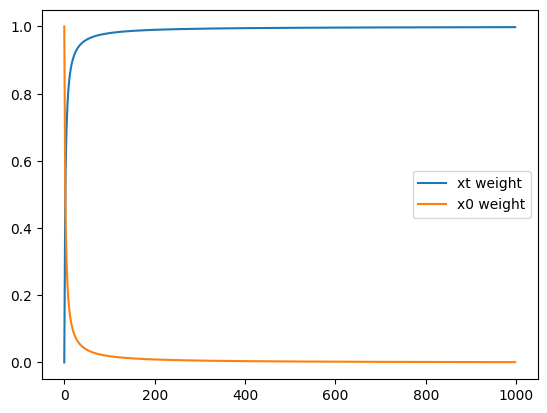

In [3]:
tt = torch.linspace(0, 1, 1000)
s_t_pair = list(zip(tt[:-1], tt[1:]))
xt_weight = []
x0_weight = []
for s, t in s_t_pair:
    xt_weight.append((s / t) ** 2)
    x0_weight.append((1 - s) * (1 - (1 - t) / (1 - s) * (s / t) ** 2))
plt.plot(range(len(s_t_pair)), xt_weight, label="xt weight")
plt.plot(range(len(s_t_pair)), x0_weight, label="x0 weight")
plt.legend()
plt.show()

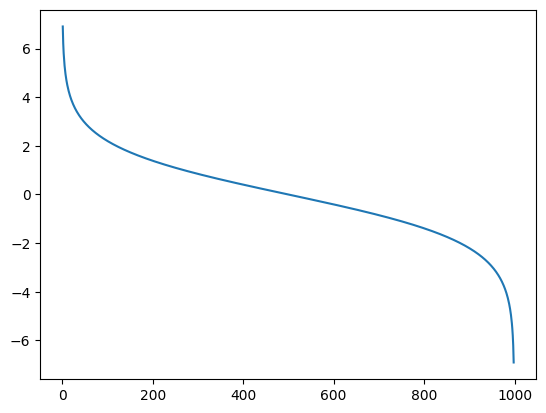

In [5]:
plt.plot(range(1000), torch.log((1 - tt) / tt))
plt.show()

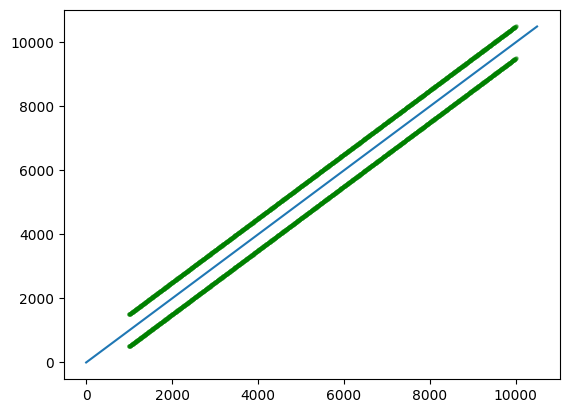

In [7]:
x = torch.linspace(1000, 10_000, 1000)
y1 = x - 500
y2 = x + 500
plt.plot([0, 10_500], [0, 10_500])
plt.scatter(x, y1, s=5, c="green", alpha=0.5)
plt.scatter(x, y2, s=5, c="green", alpha=0.5)
plt.show()

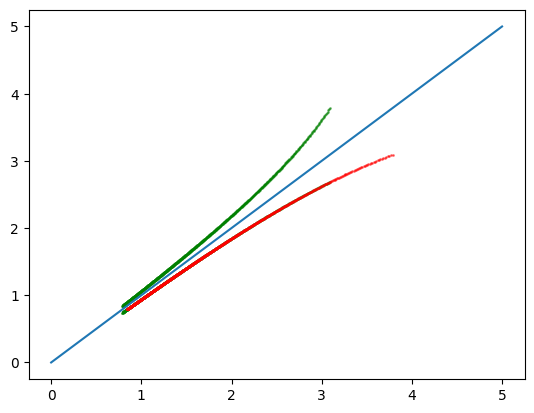

In [13]:
x = torch.linspace(1000, 10_000, 1000)
y1 = x - 500
y2 = x + 500
plt.plot([0, 5], [0, 5])
plt.scatter(10 - torch.log(x), 10 - torch.log(y1), s=1, c="green", alpha=0.5)
plt.scatter(10 - torch.log(x), 10 - torch.log(y2), s=1, c="green", alpha=0.5)
plt.scatter(10 - torch.log(y1), 10 - torch.log(x), s=1, c="red", alpha=0.5)
plt.show()

In [ ]:
font_size = 10
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": font_size,
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "figure.dpi": 250,  # high-res output
    "lines.linewidth": 2.0,
    "lines.markersize": 8,
})

In [ ]:
# Function to plot B-spline basis functions
def plot_inner_bsplines(degree, ax, exclude, additional_exclude):
    knots = np.linspace(0, 1, 10)
    n_basis = len(knots) + degree - 1
    extended_knots = np.concatenate((
        np.full(degree, knots[0]), 
        knots, 
        np.full(degree, knots[-1])
    ))

    z = np.linspace(0, 1, 500)
    for i in range(exclude, n_basis - exclude):
        if i in additional_exclude:
            continue
        coeff = np.zeros(n_basis)
        coeff[i] = 1
        spline = BSpline(extended_knots, coeff, degree)
        ax.plot(z, spline(z), color='black', alpha=0.6)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel(r"$z$")
    ax.set_ylabel("Basis Function Value")

In [ ]:
# Plot degree 1 (exclude 1 at each end)
fig1, ax1 = plt.subplots(figsize=(2.7, 2))
plot_inner_bsplines(degree=1, ax=ax1, exclude=1, additional_exclude=[5, 6, 7])
fig1.tight_layout()
fig1.savefig("./new_bspline_functions_degree1.png")
plt.show()

In [ ]:
# Plot degree 2 (exclude 2 at each end)
fig2, ax2 = plt.subplots(figsize=(2.7, 2))
plot_inner_bsplines(degree=2, ax=ax2, exclude=2, additional_exclude=[6, 7])
fig2.tight_layout()
fig2.savefig("./new_bspline_functions_degree2.png")
plt.show()

In [2]:
def test_q():
    val_est_fluxes = torch.randn((5000, 2048, 1))
    val_true_fluxes = torch.randn((2048, 1))
    ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
    left_q_points = [(1.0 - c) / 2 for c in ci_cover]
    right_q_points = [1.0 - lq for lq in left_q_points]
    actual_ci_cover = []
    for q in zip(left_q_points, right_q_points):
        q = torch.tensor(q)
        est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
        above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
        below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
        actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])
    return torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [3]:
q_list = []
for _ in tqdm.tqdm(list(range(100))):
    q_list.append(test_q())
q_tensor = torch.stack(q_list, dim=0)  # (100, q)

100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


In [6]:
q_tensor.mean(dim=0), q_tensor.std(dim=0)

(tensor([0.0508, 0.1002, 0.1503, 0.1997, 0.2495, 0.2996, 0.3497, 0.3995, 0.4495,
         0.4996, 0.5501, 0.5995, 0.6492, 0.6984, 0.7490, 0.7996, 0.8501, 0.8999,
         0.9502]),
 tensor([0.0045, 0.0057, 0.0067, 0.0086, 0.0099, 0.0105, 0.0096, 0.0096, 0.0099,
         0.0102, 0.0092, 0.0087, 0.0084, 0.0088, 0.0083, 0.0074, 0.0074, 0.0065,
         0.0049]))

In [8]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
n = 100_000
for q in ci_cover:
    s = (q * (1 - q) / n) ** 0.5
    print(f"ci[{q:.2f}]: {s:.5f}")

ci[0.05]: 0.00069
ci[0.10]: 0.00095
ci[0.15]: 0.00113
ci[0.20]: 0.00126
ci[0.25]: 0.00137
ci[0.30]: 0.00145
ci[0.35]: 0.00151
ci[0.40]: 0.00155
ci[0.45]: 0.00157
ci[0.50]: 0.00158
ci[0.55]: 0.00157
ci[0.60]: 0.00155
ci[0.65]: 0.00151
ci[0.70]: 0.00145
ci[0.75]: 0.00137
ci[0.80]: 0.00126
ci[0.85]: 0.00113
ci[0.90]: 0.00095
ci[0.95]: 0.00069
